# Anchor Constraints

In this notebook, we show how to use an [anchor constraint](https://pymde.org/mde/index.html#anchored), which
lets us pin some of the embedding vectors to specific values. This can be useful if you know a priori what some of the embedding vectors should be.

Below, we'll use an anchor constraint when laying out a binary tree: we'll pin the leaves to lie on a circle.

In [1]:
import pymde
import torch

This next cell constraints a binary tree with a specified depth. You can change the depth of the tree by changing the value of the `depth` variable.

In [2]:
depth = 9
n_items = 2**(depth + 1) - 1

edges = []
stack = [0]
while stack:
    root = stack.pop()
    first_child = root*2 + 1
    second_child = root*2 + 2
    if first_child < n_items:
        edges.append((root, first_child))
        stack.append(first_child)
    if second_child < n_items:
        edges.append((root, second_child))
        stack.append(second_child)

tree = pymde.Graph.from_edges(torch.tensor(edges))

To layout the graph, we're going to preserve the shortest path distances between all pairs of nodes. The next cell computes these distances.

In [3]:
shortest_paths_graph = pymde.preprocess.graph.shortest_paths(tree)

To use an anchor constraint, we need the indices of the items we want to pin (remember that we will pin the leaves). We get the indices of the leaves using a simple formula.

In [4]:
# these are the indices of the nodes that we will pin in place
leaves = torch.arange(2**depth) + 2**depth - 1

We want to pin the leaves to be uniformly spaced on a circle. The below cell constructs a Tensor in which the `i`th row holds the location to which the `i`th leaf should be pinned.

If you like, you can try changing the `radius` to see what effect it has on the embedding.

In [5]:
import math

radius = 20

# pin the root to be at (0, 0), and the leaves to be spaced uniformly on a circle
angles = torch.linspace(0, 2*math.pi, leaves.numel() + 1)[1:]
positions = radius * torch.stack([torch.sin(angles), torch.cos(angles)], dim=1)
positions

tensor([[ 2.4543e-01,  1.9998e+01],
        [ 4.9082e-01,  1.9994e+01],
        [ 7.3614e-01,  1.9986e+01],
        ...,
        [-4.9081e-01,  1.9994e+01],
        [-2.4542e-01,  1.9998e+01],
        [ 3.4969e-06,  2.0000e+01]])

Now that we have the leaves (the anchors) and the desired positions (their values), we can create the anchor constraint.

In [6]:
anchor_constraint = pymde.Anchored(anchors=leaves, values=positions)

We can now create the embedding. Feel free to play around with the distortion function (try changing it to `pymde.losses.Quadratic`, or `pymde.losses.Cubic`) to see what effect the choice of distortion function has on the emedding.

Apr 01 02:50:19 PM: Fitting a anchored embedding into R^2, for a graph with 1023 items and 522753 edges.
Apr 01 02:50:19 PM: `embed` method parameters: eps=1.0e-05, max_iter=100, memory_size=10
Apr 01 02:50:19 PM: iteration 000 | distortion 1.105927 | residual norm 0.00387356 | step length 20252.3 | percent change 17.2929
Apr 01 02:50:19 PM: iteration 010 | distortion 0.495885 | residual norm 8.01648e-06 | step length 1 | percent change 0.0379169
Apr 01 02:50:19 PM: Converged in 011 iterations, with residual norm 8.01648e-06
Apr 01 02:50:19 PM: Finished fitting in 0.377 seconds and 11 iterations.
Apr 01 02:50:19 PM: average distortion 0.496 | residual norm 8.0e-06


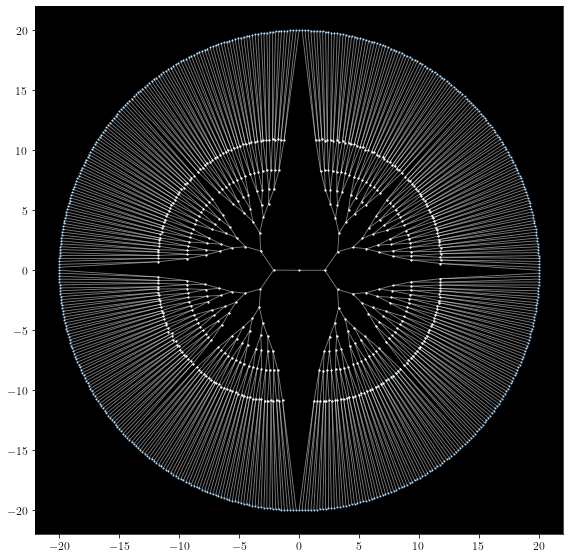

In [10]:
mde = pymde.MDE(
    n_items,
    embedding_dim=2,
    edges=shortest_paths_graph.edges,
    distortion_function=pymde.losses.WeightedQuadratic(shortest_paths_graph.distances),
    constraint=anchor_constraint,
)
mde.embed(snapshot_every=1, verbose=True)
mde.plot(edges=edges)

For fun, we can make a GIF of how the embedding was created, using the `play` method.

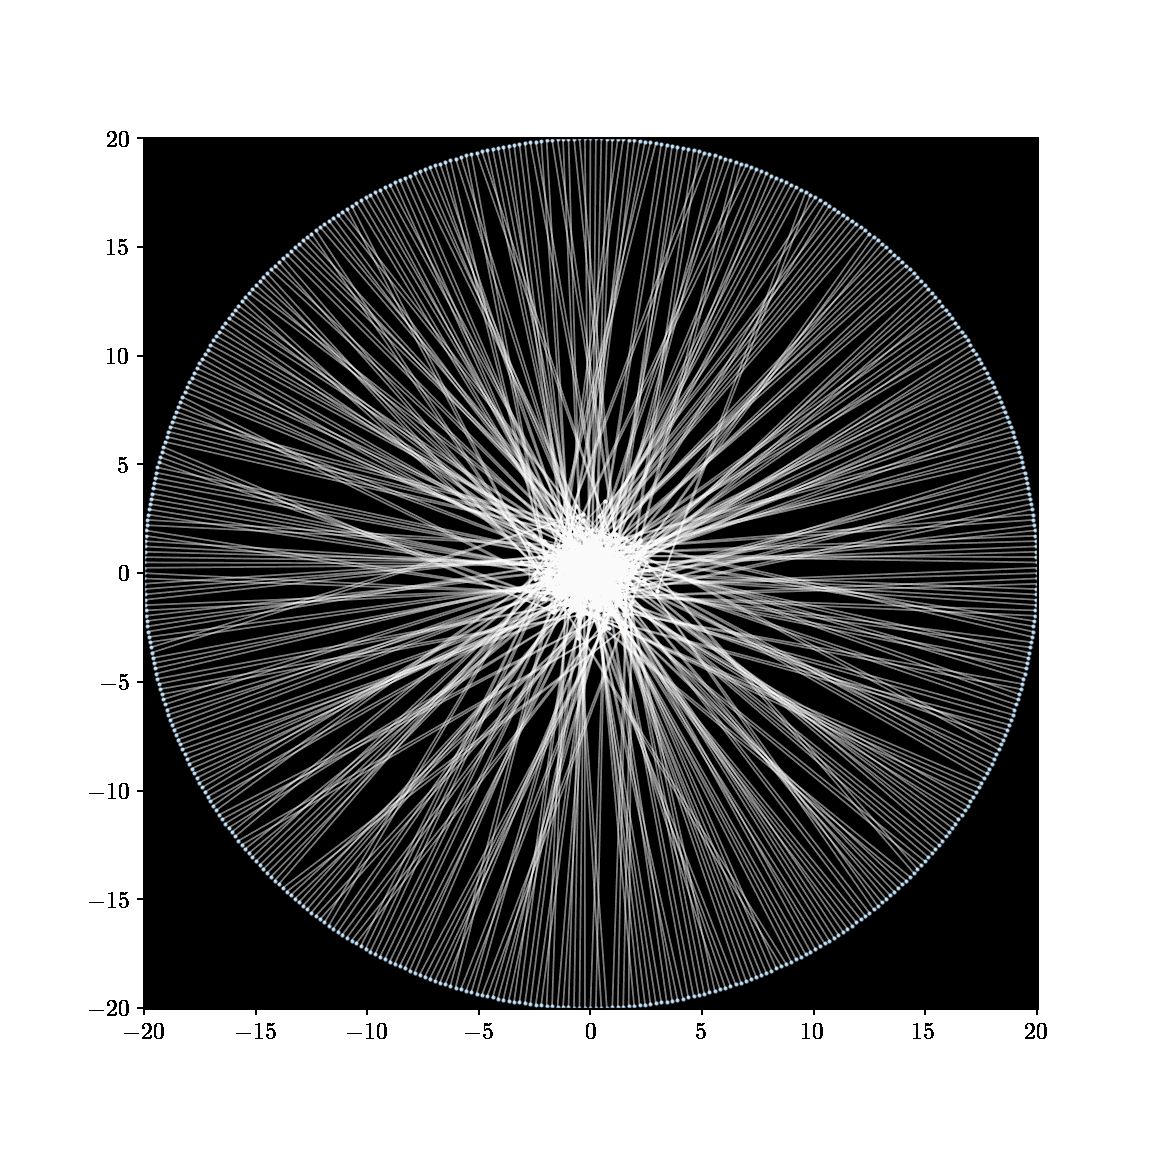

In [12]:
mde.play(edges=edges)